In [4]:
%load_ext autoreload
%autoreload 2a

import importlib
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

importlib.reload(lcwgsus)

/gpfs3/well/band/users/rbx225/GAMCC


<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

In [66]:
vcf_cols = [
    'chr', 'pos', 'ID', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT'
]

i = '/well/band/users/rbx225/GAMCC/results/imputation_comparison/topmed/lc_topmed_hc_snps_gw/vcf/all_samples/lc_vcf/lc.chr11.vcf.gz'
site = 'chr11:5227002-5227002'
command = "tabix" + " " + i + " " + site + " | tail -n 1"
data = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\t')
command = "bcftools query -l" + " " + i
name = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
col = vcf_cols + name
df = pd.DataFrame([data], columns=col)

vcf_cols = [
    'chr', 'pos', 'ID', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT'
]

i = '/well/band/users/rbx225/GAMCC/results/chip/vcf/chip_by_chr/chip.chr11.vcf.gz'
site = 'chr11:5227002-5227002'
command = "tabix" + " " + i + " " + site + " | head -n 1"
data = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\t')
command = "bcftools query -l" + " " + i
name = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
col = vcf_cols + name
df2 = pd.DataFrame([data], columns=col)

sl = pd.read_csv('data/metadata/sample_linker.csv')
hc = list(df2.columns[9:])
lc = list(df.columns[9:])
sl = sl[(~sl['Sample_Name'].str.contains('mini')) & sl['Chip_Name'].isin(hc)]
rename = {k:v for k, v in zip(sl['Chip_Name'].values, sl['Sample_Name'].values)}
order = []
for i in hc:
    order.append(rename[i])
    if rename[i] in lc:
        df = df.rename(columns = {rename[i]: i})
df = df.drop(columns = df.columns[df.columns.str.contains('GM')])
df = df.drop(columns = df.columns[df.columns.str.contains('HV')])
df = df[vcf_cols + hc]
df = df.apply(lcwgsus.extract_DS, axis = 1)
df2 = df2.apply(lcwgsus.encode_genotype, axis=1)   

In [95]:
r1 = df.iloc[0,9:].astype(float).values
r1 = df2.iloc[0,9:].astype(float).values
lcwgsus.calculate_imputation_accuracy_metrics(r2, r1)

[0.9375,
 16,
 0.926767580037711,
 186,
 0.9882352941176471,
 170,
 0.9090909090909091,
 11,
 1.0,
 5]

--- 
About full comparison

In [2]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir'][2:]

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed/"

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

# chip, lc, af = lcwgsus.imputation_calculation_preprocess(chip_vcf, quilt_vcf, af_txt, save_vcfs = False)

In [4]:
chromosomes = [str(i) for i in range(1,23)]
impaccs = []

for d in imp_dirs:
    v_lst = [d + "impacc/all_samples/by_sample/chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

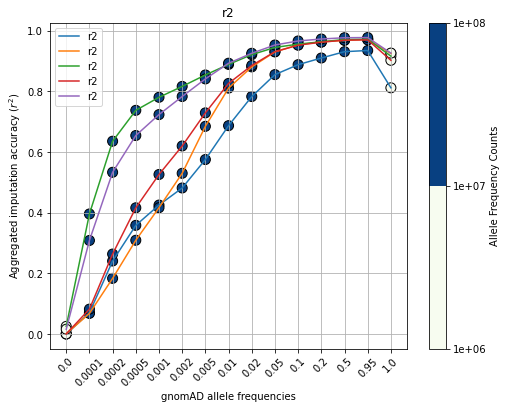

In [14]:
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
lcwgsus.plot_imputation_accuracy(dfs, title = 'r2')

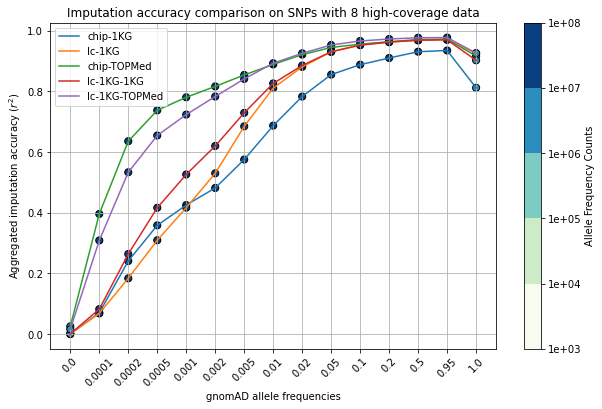

In [24]:
labels = ['chip-1KG', 'lc-1KG', 'chip-TOPMed', 'lc-1KG-1KG', 'lc-1KG-TOPMed']
title = 'Imputation accuracy comparison on SNPs with 8 high-coverage data'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

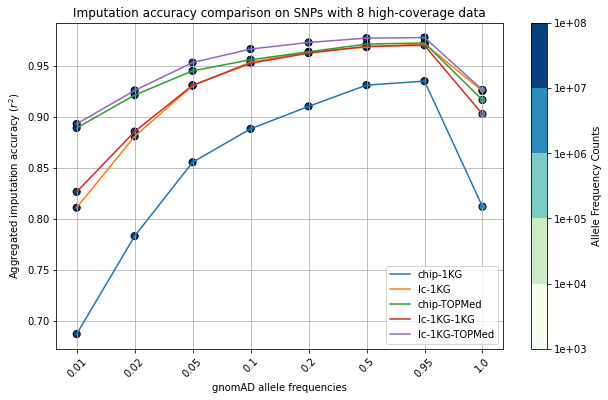

In [28]:
labels = ['chip-1KG', 'lc-1KG', 'chip-TOPMed', 'lc-1KG-1KG', 'lc-1KG-TOPMed']
title = 'Imputation accuracy comparison on SNPs with 8 high-coverage data'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= 0.01]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

---
About by ethnicity group and by cc

In [6]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir']
imp_dirs = [imp_dirs[0], imp_dirs[7], imp_dirs[10]]

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = imp_dirs

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

chromosomes = [str(i) for i in range(1,23)]
impaccs = []

for d in imp_dirs:
    v_lst = [d + 'impacc/all_samples/by_sample/' + "chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

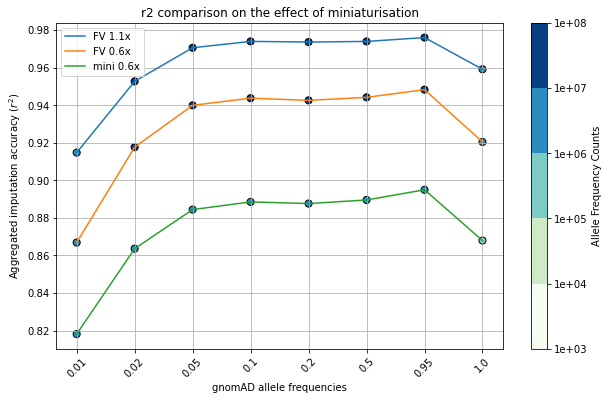

In [8]:
labels = ['FV 1.1x', 'FV 0.6x', 'mini 0.6x']
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
t = 0.01
title = 'r2 comparison on the effect of miniaturisation'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

In [114]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir'][1]

case_controls = ['non-malaria_control', 'mild_malaria', 'severe_malaria']
ethnicities = ['fula', 'jola', 'mandinka', 'wollof']

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = imp_dirs

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

chromosomes = [str(i) for i in range(1,23)]
impaccs = []

d = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed_high_info/impacc/by_eth/by_sample/"

for e in ethnicities:
    v_lst = [d + e + ".chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

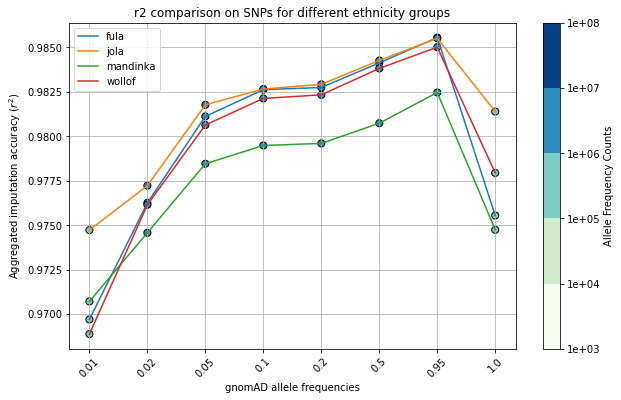

In [119]:
labels = ethnicities
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
t = 0.01
title = 'r2 comparison on SNPs for different ethnicity groups'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

In [120]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir'][1]

case_controls = ['non-malaria_control', 'mild_malaria', 'severe_malaria']
ethnicities = ['fula', 'jola', 'mandinka', 'wollof']

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = imp_dirs

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

chromosomes = [str(i) for i in range(1,23)]
impaccs = []

d = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed_high_info/impacc/by_cc/by_sample/"

for c in case_controls:
    v_lst = [d + c + ".chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

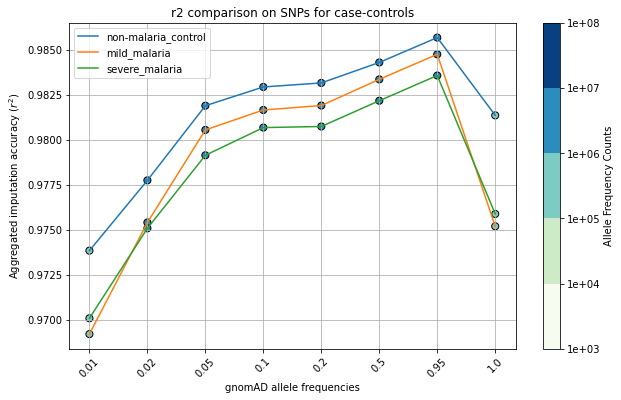

In [122]:
labels = case_controls
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
t = 0.01
title = 'r2 comparison on SNPs for case-controls'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

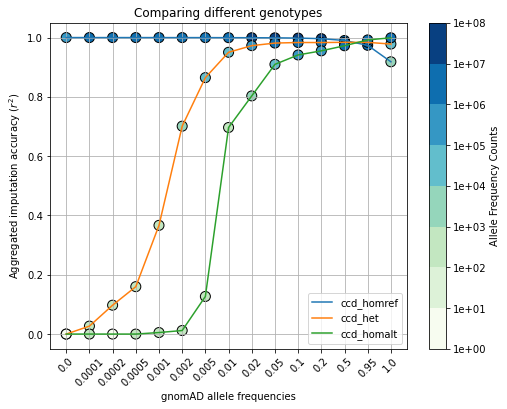

In [196]:
dfs = [h[['AF', 'ccd_homref', 'ccd_homref_AC']], h[['AF', 'ccd_het', 'ccd_het_AC']], h[['AF', 'ccd_homalt', 'ccd_homalt_AC']]]
plot_imputation_accuracy(dfs, title = 'Comparing different genotypes')